In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import scipy

%matplotlib inline

import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import h5py
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model

Using TensorFlow backend.


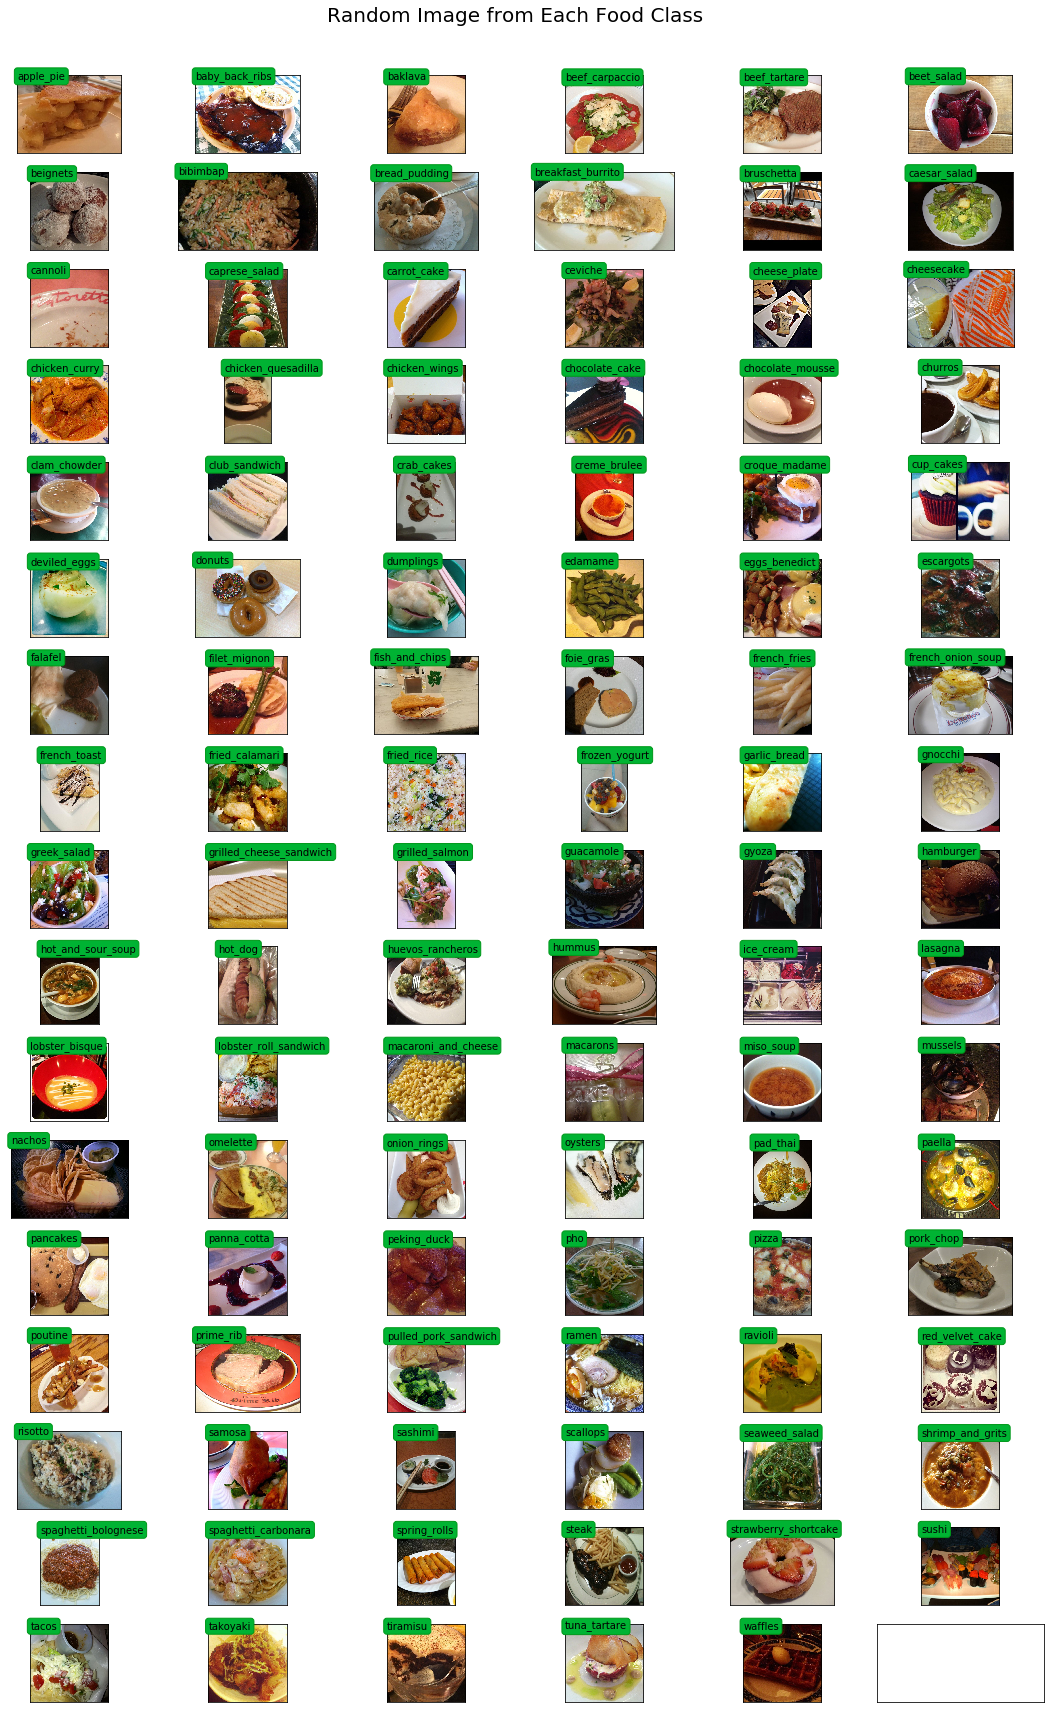

In [6]:
root_dir = 'food-101/images/'
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Random Image from Each Food Class', fontsize=20)
sorted_food_dirs = sorted(os.listdir(root_dir))
for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i*cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, food_dir, size=10, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [7]:
class_to_ix = {}
ix_to_class = {}
with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]
    class_to_ix = dict(zip(classes, range(len(classes))))
    ix_to_class = dict(zip(range(len(classes)), classes))
    class_to_ix = {v: k for k, v in ix_to_class.items()}
sorted_class_to_ix = collections.OrderedDict(sorted(class_to_ix.items()))

In [10]:
%%time
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load dataset images and resize to meet minimum width and height pixel size
def load_images(root, min_side=160):
    all_imgs = []
    all_classes = []
    resize_count = 0
    invalid_count = 0
    for i, subdir in enumerate(listdir(root)):
        imgs = listdir(join(root, subdir))
        class_ix = class_to_ix[subdir]
        print(i, class_ix, subdir)
        for img_name in imgs:
            img_arr = img.imread(join(root, subdir, img_name))
            img_arr_rs = img_arr
            try:
                w, h, _ = img_arr.shape
                if w < min_side:
                    wpercent = (min_side/float(w))
                    hsize = int((float(h)*float(wpercent)))
                    #print('new dims:', min_side, hsize)
                    img_arr_rs = imresize(img_arr, (min_side, hsize))
                    resize_count += 1
                elif h < min_side:
                    hpercent = (min_side/float(h))
                    wsize = int((float(w)*float(hpercent)))
                    #print('new dims:', wsize, min_side)
                    img_arr_rs = imresize(img_arr, (wsize, min_side))
                    resize_count += 1
                #all_imgs.append(img_arr_rs)
                #all_classes.append(class_ix)
            except:
                print('Skipping bad image: ', subdir, img_name)
                invalid_count += 1
    print(len(all_imgs), 'images loaded')
    print(resize_count, 'images resized')
    print(invalid_count, 'images skipped')
    return np.array(all_imgs), np.array(all_classes)
    
X_test, y_test = load_images('test160', min_side=160)

0 0 apple_pie
1 1 baby_back_ribs
2 2 baklava
3 3 beef_carpaccio
4 4 beef_tartare
5 5 beet_salad
6 6 beignets
7 7 bibimbap
8 8 bread_pudding
9 9 breakfast_burrito
10 10 bruschetta
11 11 caesar_salad
12 12 cannoli
13 13 caprese_salad
14 14 carrot_cake
15 15 ceviche
16 16 cheesecake
17 17 cheese_plate
18 18 chicken_curry
19 19 chicken_quesadilla
20 20 chicken_wings
21 21 chocolate_cake
22 22 chocolate_mousse
23 23 churros
24 24 clam_chowder
25 25 club_sandwich
26 26 crab_cakes
27 27 creme_brulee
28 28 croque_madame
29 29 cup_cakes
30 30 deviled_eggs
31 31 donuts
32 32 dumplings
33 33 edamame
34 34 eggs_benedict
35 35 escargots
36 36 falafel
37 37 filet_mignon
38 38 fish_and_chips
39 39 foie_gras
40 40 french_fries
41 41 french_onion_soup
42 42 french_toast
43 43 fried_calamari
44 44 fried_rice
45 45 frozen_yogurt
46 46 garlic_bread
47 47 gnocchi
48 48 greek_salad
49 49 grilled_cheese_sandwich
50 50 grilled_salmon
51 51 guacamole
52 52 gyoza
53 53 hamburger
54 54 hot_and_sour_soup
55 55 ho

In [11]:
%%time
X_train, y_train = load_images('train160', min_side=160)

0 0 apple_pie
1 1 baby_back_ribs
2 2 baklava
3 3 beef_carpaccio
4 4 beef_tartare
5 5 beet_salad
6 6 beignets
7 7 bibimbap
8 8 bread_pudding
Skipping bad image:  bread_pudding 1375816.jpg
9 9 breakfast_burrito
10 10 bruschetta
11 11 caesar_salad
12 12 cannoli
13 13 caprese_salad
14 14 carrot_cake
15 15 ceviche
16 16 cheesecake
17 17 cheese_plate
18 18 chicken_curry
19 19 chicken_quesadilla
20 20 chicken_wings
Skipping bad image:  chicken_wings 1009927.jpg
21 21 chocolate_cake
22 22 chocolate_mousse
23 23 churros
24 24 clam_chowder
25 25 club_sandwich
26 26 crab_cakes
27 27 creme_brulee
28 28 croque_madame
29 29 cup_cakes
30 30 deviled_eggs
31 31 donuts
32 32 dumplings
33 33 edamame
34 34 eggs_benedict
35 35 escargots
36 36 falafel
37 37 filet_mignon
38 38 fish_and_chips
39 39 foie_gras
40 40 french_fries
41 41 french_onion_soup
42 42 french_toast
43 43 fried_calamari
44 44 fried_rice
45 45 frozen_yogurt
46 46 garlic_bread
47 47 gnocchi
48 48 greek_salad
49 49 grilled_cheese_sandwich
50 

In [2]:
%%time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
BATCH_SIZE = 16
INPUT_SIZE = (224, 224)
EPOCH = 32
n_classes = 101
TRAIN_PATH = 'train/'
TEST_PATH = 'test/'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

train_datagen = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,  # set input mean to 0 over the dataset
                                   samplewise_center=False,  # set each sample mean to 0
                                   featurewise_std_normalization=False,  # divide inputs by std of the dataset
                                    samplewise_std_normalization=False,  # divide each input by its std
                                   zoom_range=[.8, 1],
                                   rotation_range=45,
#                                    zca_whitening=True,
                                   shear_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   channel_shift_range=30,
                                   fill_mode='reflect',
                                   validation_split=0.2
                                  )

#train_datagen.config['random_crop_size'] = (299, 299)

train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                    target_size=INPUT_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                   seed=11
                                                   )

val_generator = train_datagen.flow_from_directory(TEST_PATH,
                                                  target_size=INPUT_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                               seed=11
                                                   )


Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.
Wall time: 3.04 s


In [3]:
%%time
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import SGD
from keras.regularizers import l2
import keras.backend as K
import math
from keras.applications.resnet_v2   import ResNet101V2 
from keras.applications.resnet_v2   import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.layers import Input
K.clear_session()

resnet_base = ResNet101V2(weights='imagenet',
                              include_top=False,
                              input_tensor=Input(shape=(INPUT_SIZE[0], INPUT_SIZE[1], 3))
                             )

x = resnet_base.output
x = AveragePooling2D(pool_size=(7, 7))(x)
x = Dropout(.4)(x)
x = Flatten()(x)
predictions = Dense(n_classes, init='glorot_uniform', W_regularizer=l2(.0005), activation='softmax')(x)

model = Model(inputs=resnet_base.input, outputs=predictions)


opt = SGD(lr=.01, momentum=.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model4.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('model4.log')

def schedule(epoch):
    if epoch < 10:
        return .01
    elif epoch < 20:
        return .001
    else:
        return .0001
lr_scheduler = LearningRateScheduler(schedule)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

D:\lxd\anaconda\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(101, activation="softmax", kernel_initializer="glorot_uniform", kernel_regularizer=<keras.reg...)`


In [4]:
%%time
history = model.fit_generator(train_generator,
                              steps_per_epoch = train_generator.samples // BATCH_SIZE,
                              validation_data = val_generator,
                              validation_steps = val_generator.samples // BATCH_SIZE,
                              epochs=32,
                              verbose=1,
                              callbacks=[lr_scheduler, csv_logger, checkpointer])

Epoch 1/32
4734/4734 [==============================] - 2099s 443ms/step - loss: 4.5735 - accuracy: 0.0279 - val_loss: 4.0394 - val_accuracy: 0.1522

Epoch 00001: val_loss improved from inf to 4.03935, saving model to model4.01-4.04.hdf5
Epoch 2/32
4734/4734 [==============================] - 2068s 437ms/step - loss: 2.9358 - accuracy: 0.3246 - val_loss: 2.6940 - val_accuracy: 0.3466

Epoch 00002: val_loss improved from 4.03935 to 2.69396, saving model to model4.02-2.69.hdf5
Epoch 3/32
4734/4734 [==============================] - 2075s 438ms/step - loss: 2.3260 - accuracy: 0.4649 - val_loss: 3.0023 - val_accuracy: 0.4008

Epoch 00003: val_loss did not improve from 2.69396
Epoch 4/32
4734/4734 [==============================] - 2076s 439ms/step - loss: 2.0754 - accuracy: 0.5219 - val_loss: 3.4580 - val_accuracy: 0.4820

Epoch 00004: val_loss did not improve from 2.69396
Epoch 5/32
4734/4734 [==============================] - 2078s 439ms/step - loss: 1.9075 - accuracy: 0.5635 - val_loss:

In [5]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

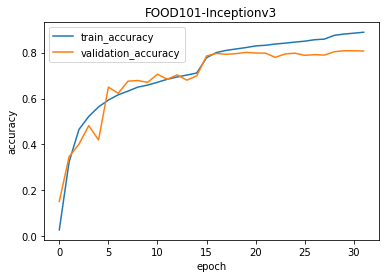

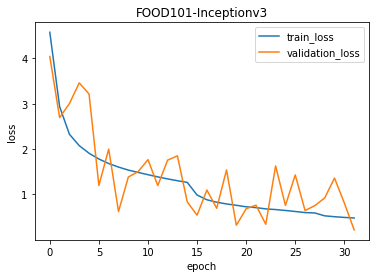

In [6]:
plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')